**Programming Exercise 1**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.colors import ListedColormap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# a)
N = 30

np.random.seed(123)

X1 = np.random.multivariate_normal([1, 1], [[1, 0], [0, 1]], N)
X1 = np.concatenate((X1, 1.0 * np.ones((N, 1))), axis=1)
X2 = np.random.multivariate_normal([-1, -1], [[1, 0], [0, 1]], N)
X2 = np.concatenate((X2, 2.0 * np.ones((N, 1))), axis=1)
X3 = np.random.multivariate_normal([2, 0], [[1, 0], [0, 1]], N)
X3 = np.concatenate((X3, 3.0 * np.ones((N, 1))), axis=1)

X = np.concatenate((X1, X2, X3))

In [3]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [4]:
class LDA:
    ''' An implementation of Linear Discriminant Analysis classifier
    
    A classifier with a linear decision boundary, generated by fitting 
    class conditional densities to the data and using Bayes’ rule.
    '''
    
    def __init__(self):
        pass
    
    def fit(self, X_train, y_train):
        if X_train is None:
            raise Exception('Training feature data has not bee provided')
        
        if y_train is None:
            raise Exception('Training prediction data has not been provided')
            
        if X_train.shape[0] != y_train.shape[0]:
            raise Exception('Size of first dimension for both train sets does not match')
            
        self.X_train = X_train
        self.y_train = y_train.astype('int64')
        
        train_set_size = float(self.X_train.shape[0])
        no_features = self.X_train.shape[1]
        
        # Retrieve class labels and their respective counts in the train set
        self.classes_, self.class_sizes_ = np.unique(self.y_train, return_counts=True)
        
        # Estimate probabilities of each class
        self.priors_ = np.array([class_size / train_set_size for class_size in self.class_sizes_])
        
        # Estimate means of each class
        self.means_ = np.array([np.sum(self.X_train[self.y_train == class_label], axis=0) / class_size for class_label, class_size in zip(self.classes_, self.class_sizes_)])
        
        # Estimate covariance
        self.covariance_ = np.zeros((no_features, no_features))
        
        for class_label, class_prior, class_mean in zip(self.classes_, self.priors_, self.means_):            
            for x in self.X_train[self.y_train == class_label]:
                x = x.reshape(-1, 1)
                self.covariance_ += np.matmul((x - class_mean), (x - class_mean).T) / (train_set_size - len(self.classes_))
    
    def predict(self, X_test):
        if not hasattr(self, 'classes_'):
            raise Exception('Fit data first before predicting')
            
        y_pred = np.array([])
        
        cov_inv = np.linalg.inv(self.covariance_)
            
        for x in X_test:
            class_predictions = list()
            
            for class_label, class_prior, class_mean in zip(self.classes_, self.priors_, self.means_):
                class_pred = np.log(class_prior) + x @ cov_inv @ class_mean.T - 0.5 * class_mean @ cov_inv @ class_mean.T

                class_predictions.append(class_pred)
                
            y_pred = np.append(y_pred, self.classes_[np.argmax(class_predictions)])
        
        return y_pred.reshape(-1, 1)

In [5]:
lda = LDA()
lda.fit(X[:, [0, 1]], X[:, 2])

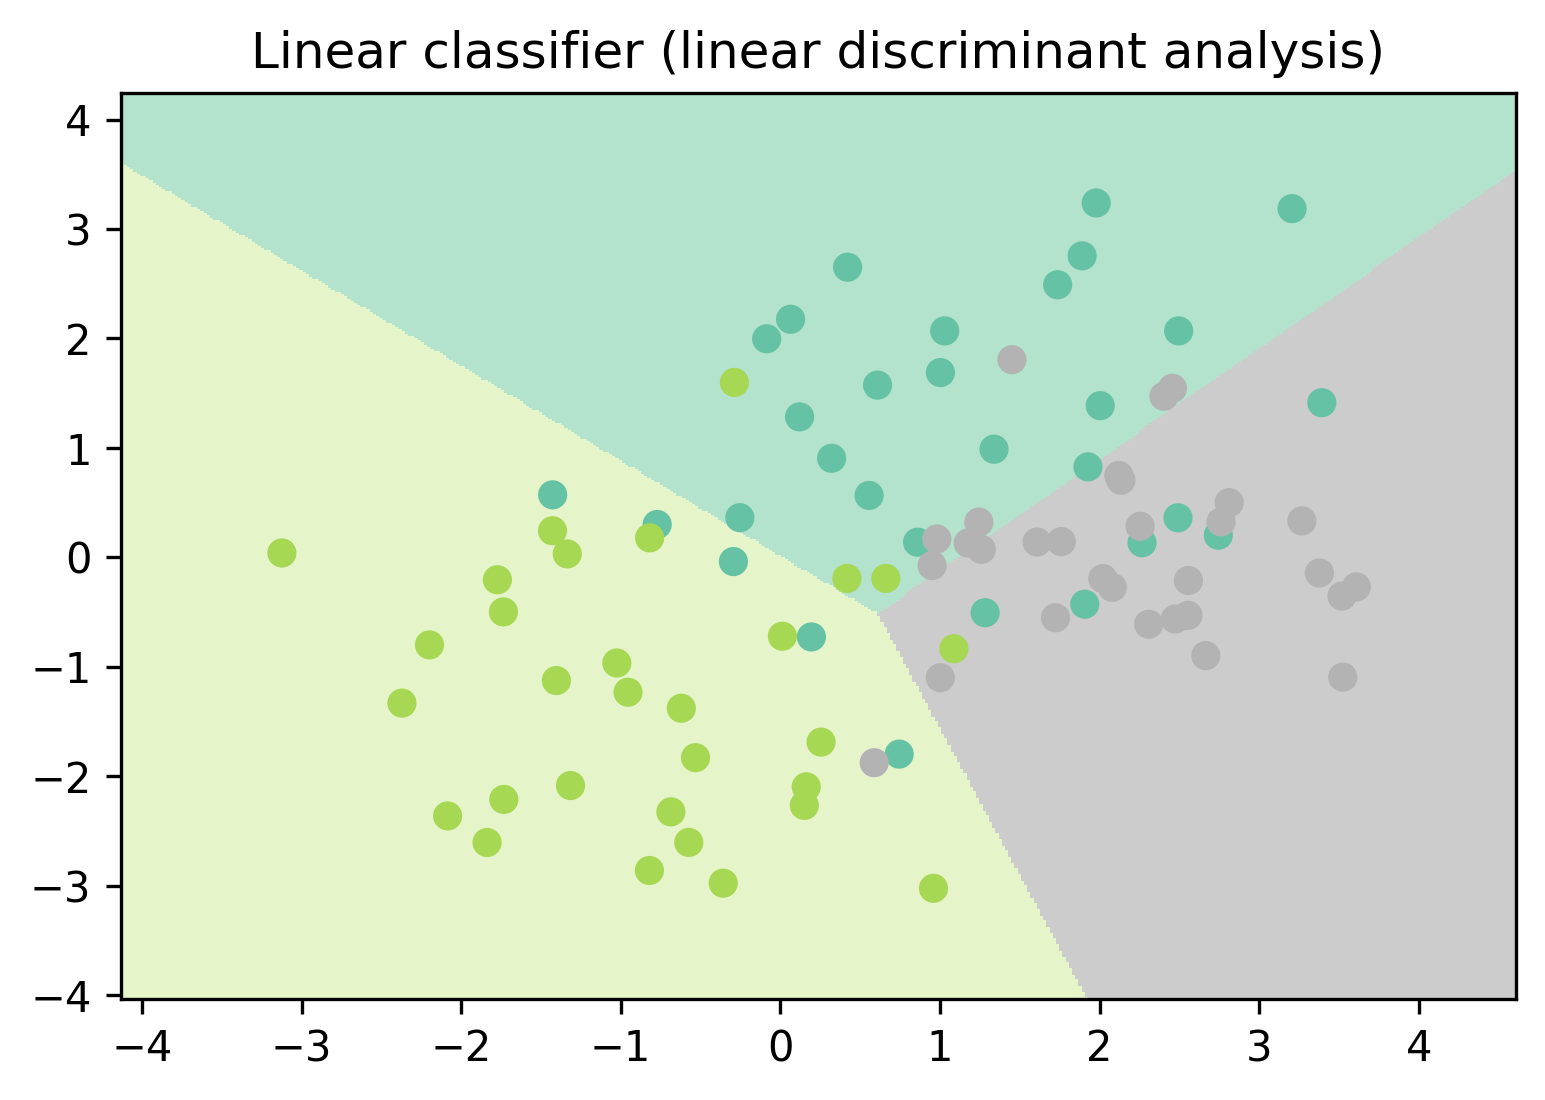

In [6]:
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(dpi=300)
plt.pcolormesh(xx, yy, Z, cmap='Pastel2', shading='auto')

plt.scatter(X[:, 0], X[:, 1], c=X[:, 2], cmap='Set2')
plt.title('Linear classifier (linear discriminant analysis)')
plt.show()

Comparing to results from Example 8.1

In [7]:
lda_sklearn = LinearDiscriminantAnalysis()
lda_sklearn.fit(X[:, [0, 1]], X[:, 2])

LinearDiscriminantAnalysis()

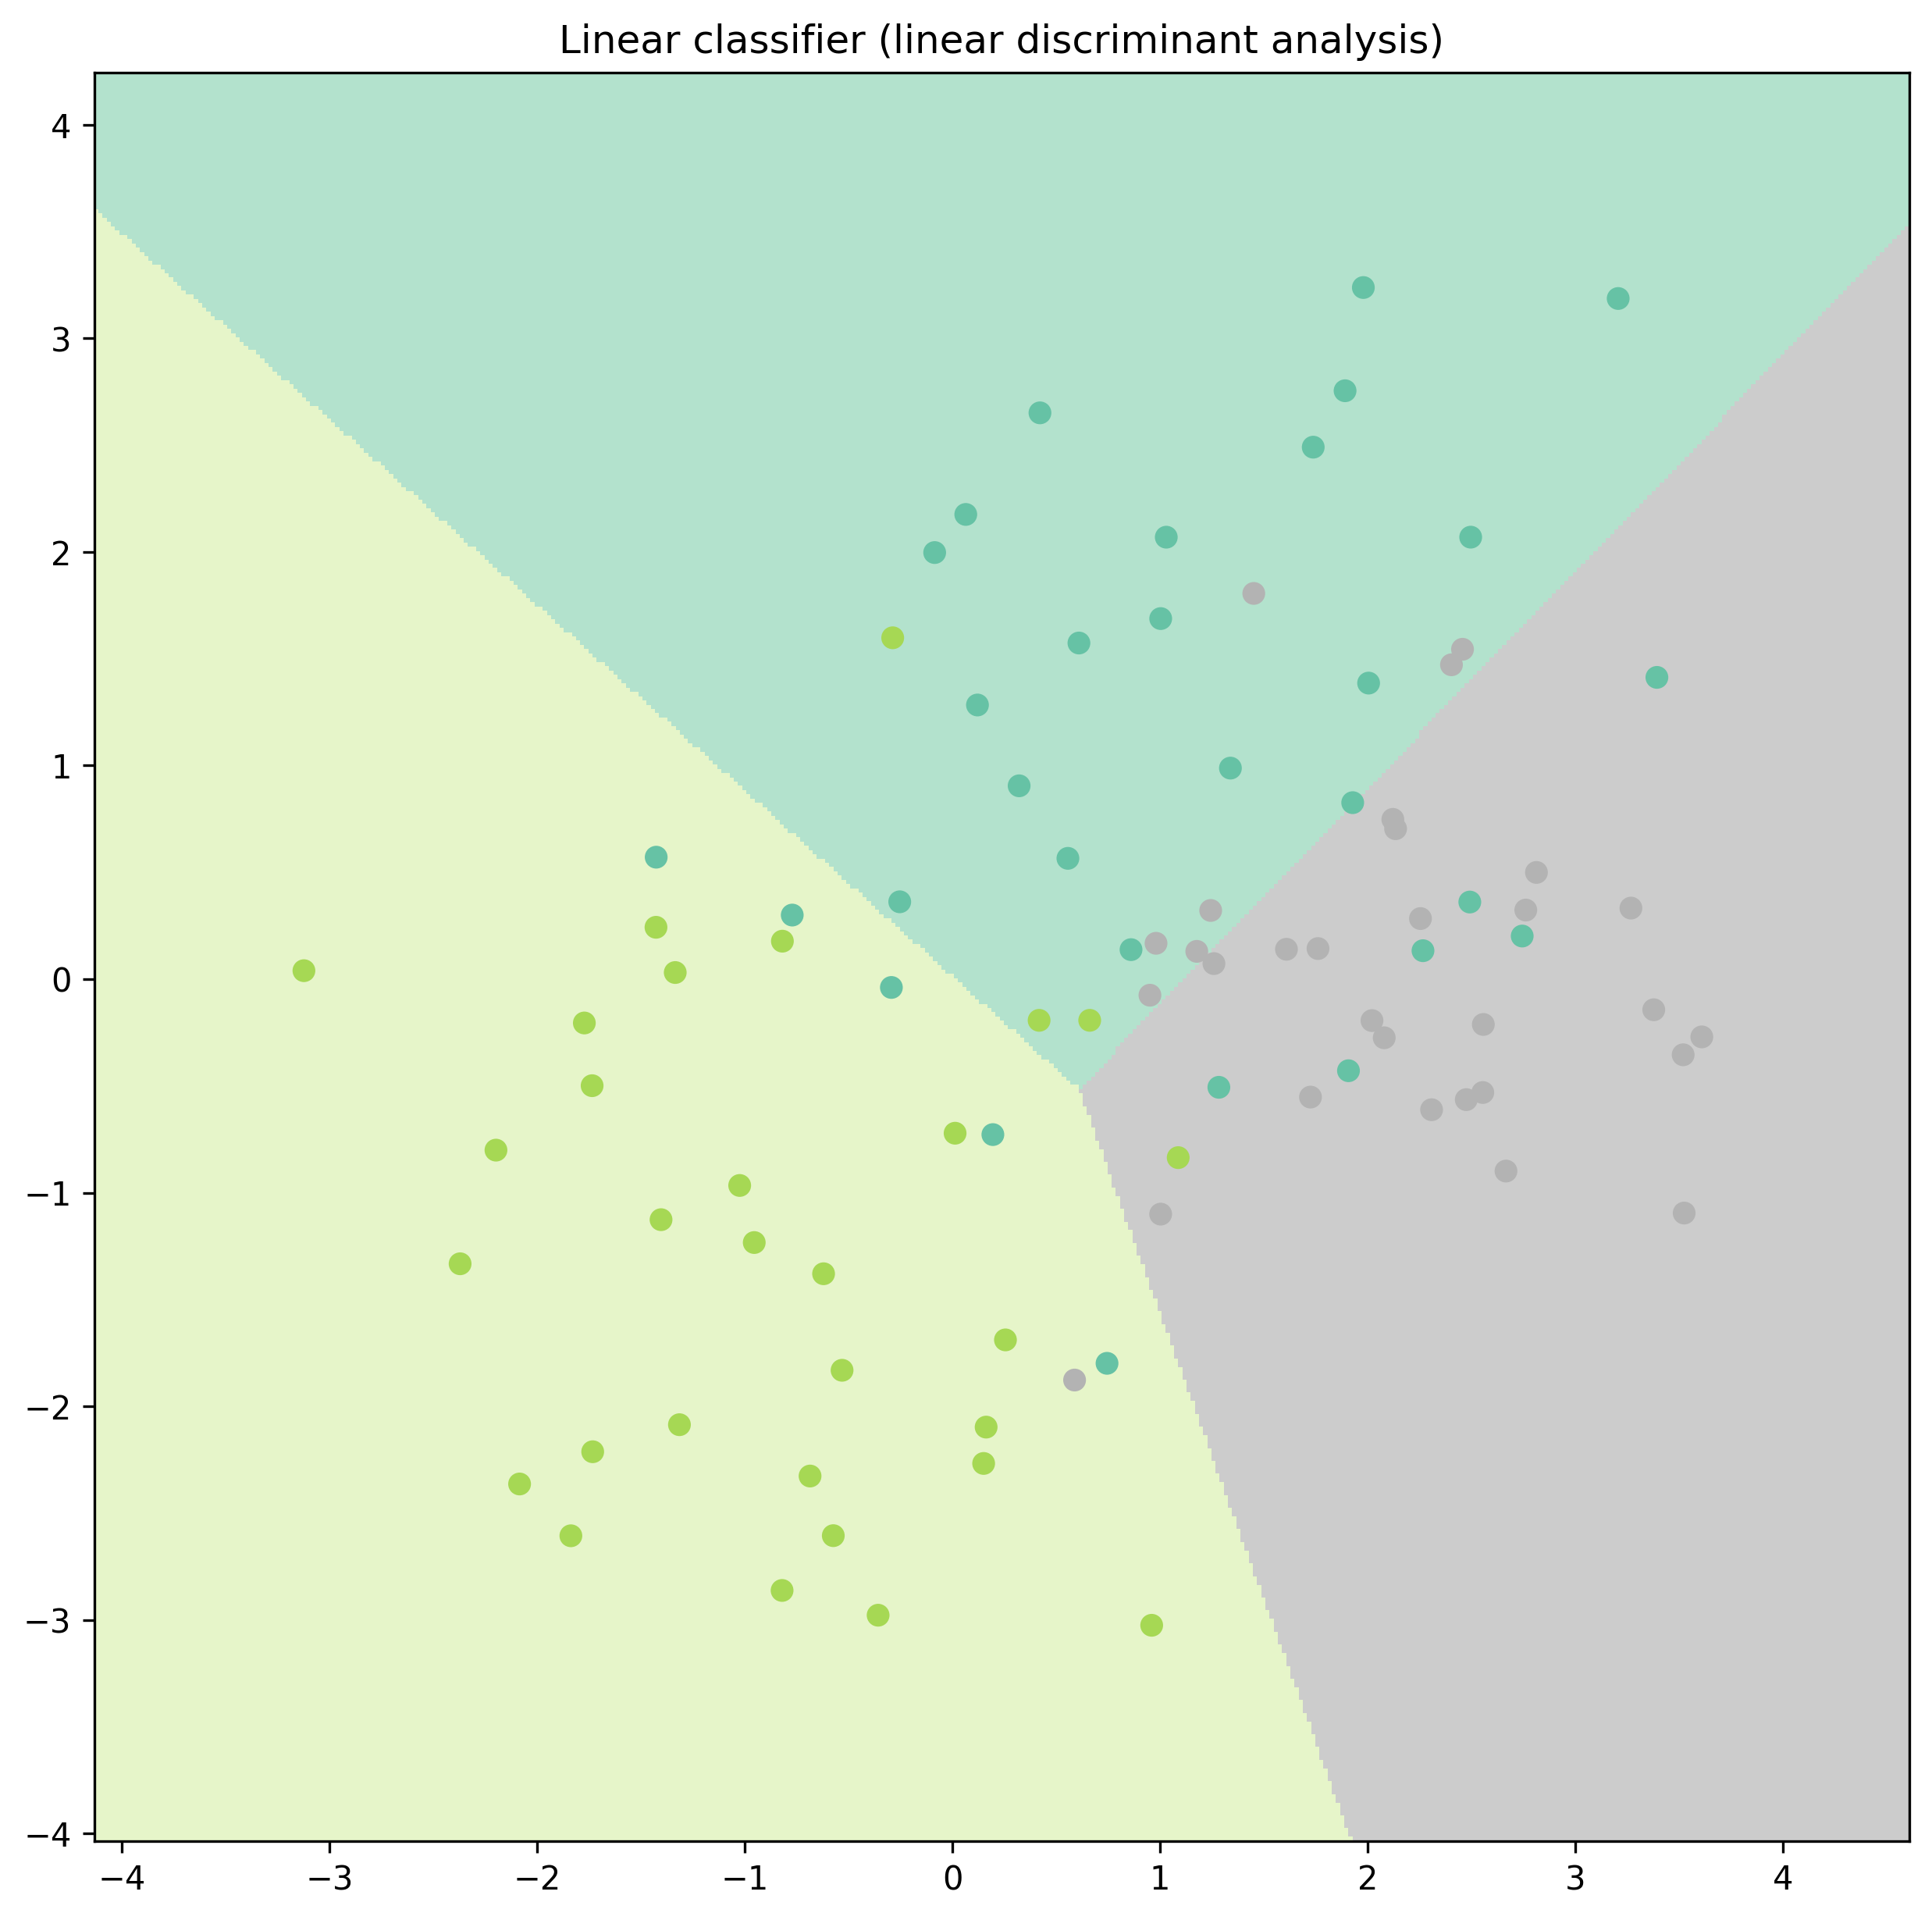

In [8]:
Z_sklearn = lda_sklearn.predict(np.c_[xx.ravel(), yy.ravel()])
Z_sklearn = Z_sklearn.reshape(xx.shape)

plt.figure(figsize=(10, 10), dpi=300)
plt.pcolormesh(xx, yy, Z, cmap='Pastel2', shading='auto')

plt.scatter(X[:, 0], X[:, 1], c=X[:, 2], cmap='Set2')
plt.title('Linear classifier (linear discriminant analysis)')
plt.show()

In [9]:
_, counts = np.unique(np.equal(Z, Z_sklearn), return_counts=True)

print(f'Implementation mesh differs from sklearn mesh on {counts[0]} out of {counts[1]} mesh points')
print(f'This yields an accuracy rate to the sklearn implementation of {counts[1] / np.sum(counts) * 100:.2f}%')

Implementation mesh differs from sklearn mesh on 1485 out of 179433 mesh points
This yields an accuracy rate to the sklearn implementation of 99.18%


In [10]:
# b)
!curl -o emails.csv https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  686k  100  686k    0     0   233k      0  0:00:02  0:00:02 --:--:--  233k


In [11]:
df = pd.read_csv('./emails.csv')

X = df.iloc[:, :57].to_numpy()
y = df.iloc[:, 57].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=100, random_state=1, shuffle=True)

In [12]:
lda = LDA()
lda.fit(X_train, y_train)

print('Generalization error using validation approach of LDA implementation is:', zero_one_loss(y_test, lda.predict(X_test)))

Generalization error using validation approach of LDA implementation is: 0.41000000000000003


In [13]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

print('Generalization error using validation approach of scikit-learn LDA is:', zero_one_loss(y_test, lda.predict(X_test)))

Generalization error using validation approach of scikit-learn LDA is: 0.10999999999999999


In [14]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

print('Generalization error using validation approach of scikit-learn kNN classifer implementation is:', zero_one_loss(y_test, knn.predict(X_test)))

Generalization error using validation approach of scikit-learn kNN classifer implementation is: 0.25
